In [48]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
import agent_utils
import regression_analysis as r
import pickle
import os
import sys

sys.path.append(os.path.abspath(os.path.join("..")))

import visual
import utils

## Colors Setup

In [2]:
cmap_name = "winter"

# Define transparant to color cmap
ncolors = 256
color_array = plt.get_cmap(cmap_name)(range(ncolors))

color_array[:, -1] = np.linspace(0.0, 1.0, ncolors)

map_object = LinearSegmentedColormap.from_list(name="{}_alpha".format(cmap_name), colors=color_array)

def is_colormap_registered(cmap_name):
    try:
        plt.get_cmap(cmap_name)
        return True
    except ValueError:
        return False

if not is_colormap_registered(cmap_name + "_alpha"):
    matplotlib.colormaps.register(cmap=map_object)

In [52]:
rgb_green = (17/255, 119/255, 51/255)
rgb_skyblue = (136/255, 204/255, 238/255)
rgb_magenta = (170/255, 68/255, 153/255)

colors = [rgb_green, rgb_skyblue, rgb_magenta]

In [53]:
world_nums = sorted([int(file[6:-4]) for file in os.listdir("../../../figures/stimuli/inference/final/")])
world_idxs = {w:idx for idx, w in list(enumerate(world_nums))}

## Procedures

In [77]:
# Heatmap visualization code

def load_human_heatmap(trial_num, condition):
    with open(f"heatmaps/human_trial_{condition}_test_{trial_num}_cut_300_rt_cleaned.pickle", "rb") as f:
        hm = pickle.load(f)

    return hm

def visualize_heatmap(hm, trial_num, ax=None, condition="vision", cmap="winter_alpha", axis=False, grain="fine"):

    if condition == "occluded":
        folder = "occluded"
    else:
        folder = "final"

    img = plt.imread("../../../figures/stimuli/inference/{}/world_{}.png".format(folder, trial_num))
    if ax is None:
        _, ax = plt.subplots()
    ax.imshow(img)
    
    if grain == "fine":
        x = np.arange(0, 601)
        y = np.arange(0, 501)
    elif grain == "coarse":
        x = np.arange(10, 610, 20)
        y = np.arange(10, 510, 20)

    if cmap == "viridis":
        ax.contourf(x, y, hm, cmap=cmap, alpha=0.3)
    else:
        ax.contourf(x, y, hm, cmap=cmap)
    
    
    if not axis:
        # ax.axis("off")
        ax.tick_params(bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False, labelright=False, labeltop=False)

    return ax

def visualize_human_cross_cond(trial_num):

    _, axes = plt.subplots(1, 3, figsize=(12, 4))

    hm_v = load_human_heatmap(trial_num, "vision")
    hm_a = load_human_heatmap(trial_num, "audio")
    hm_o = load_human_heatmap(trial_num, "occluded")

    visualize_heatmap(hm_v, trial_num, ax=axes[0], condition="vision", cmap="winter_alpha", grain="fine")
    visualize_heatmap(hm_a, trial_num, ax=axes[1], condition="audio", cmap="winter_alpha", grain="fine")
    visualize_heatmap(hm_o, trial_num, ax=axes[2], condition="occluded", cmap="winter_alpha", grain="fine")
    
    axes[0].set_title("No Sound + Ball Visible")
    axes[1].set_title("Sound + Ball Visible")
    axes[2].set_title("Sound + Ball Occluded")

def create_filename(model_type, evidence, thr=None, unc=None, sw=None, num_samples=None, start_sim=None, vbw=None, sbw=None, tb=None, tbw=None, beta=None, hole_select="softmax", vision_prior="vision", audio_prior="uniform", phys_params=(0.3, 0.0, 0.7)):

    dn, cm, cs = phys_params

    filename = f"{model_type}_{evidence}_"

    if model_type == "smart" or model_type == "sequential":
        filename += f"hole_select_{hole_select}_"

        if hole_select == "softmax":
            assert beta is not None
            filename += f"beta_{beta}_"    

    if thr is not None:
        filename += f"runs_30_threshold_{thr}_"

    if unc is not None:
        filename += f"uncertainty_{unc}_"

    if num_samples is not None:
        filename += f"num_samples_{num_samples}_"

    if vbw is not None:
        filename += f"bwv_{vbw}_"

    if sw is not None:
        filename += f"sample_weight_{sw}_"

    if sbw is not None:
        filename += f"bws_{sbw}_"

    if tb is not None:
        filename += f"timing_bins_{tb}_bwt_{tbw}_"

    if start_sim is not None:
        filename += f"start_sim_{start_sim}_"

    if model_type == "bandit" or model_type == "uniform_sampler":
        filename += "prior_vision_"
    elif model_type == "mixed":
        filename += "prior_uniform_"
    elif model_type == "smart" or model_type == "sequential":
        filename += f"prior_{vision_prior}_{audio_prior}_"

    filename += f"phys_params_{dn}_{cm}_{cs}.pkl"

    return filename

def get_trial_hm(world_num, model_pred):
    tr_idx = world_idxs[world_num]
    start = tr_idx*(501*601)
    end = (tr_idx+1)*(501*601)

    return model_pred[start:end].reshape(501, 601)

def visualize_trial(condition, tr_num, primary_pred, uniform_pred, vf_pred=None, world_idxs=world_idxs, cut=None, model_titles=None, condition_title=False):

    human_hm = r.load_human_heatmap(tr_num, condition, cut=cut)

    tr_idx = world_idxs[tr_num]
    start = tr_idx*(501*601)
    end = (tr_idx+1)*(501*601)

    primary_hm = primary_pred[start:end].reshape(501, 601)
    uniform_hm = uniform_pred[start:end].reshape(501, 601)

    if vf_pred is not None:
        vf_hm = vf_pred[start:end].reshape(501, 601)
        nplots = 4
        hms = [human_hm, primary_hm, uniform_hm, vf_hm]
    else:
        nplots = 3
        hms = [human_hm, primary_hm, uniform_hm]

    for hm in hms:
        hm[hm < 0] = 0.0

    _, axes = plt.subplots(1, nplots, figsize=(15 if nplots == 3 else 20, 5))

    for ax, hm in zip(axes, hms):
        visualize_heatmap(hm, tr_num, ax=ax, condition=condition)

    if model_titles is not None:
        assert len(model_titles) == nplots
        for ax, title in zip(axes, model_titles):
            ax.set_title(title)

    if condition_title:
        cond_dict = {"vision": "No Sound + Ball Visible", "audio": "Sound + Ball Visible", "occluded": "Sound + Ball Occluded"}
        cond_name = cond_dict[condition]
        axes[0].set_ylabel(cond_name, fontsize=12)

    return axes

# Model visualization code

def compute_pmf(counts, inf_type="independent"):
    if inf_type == "independent":
        norm = np.sum(counts, axis=1)[:,None]
    elif inf_type == "joint":
        norm = np.sum(counts, axis=(1,2))[:,None,None]
    else:
        raise ValueError("Unknown inference type")
    return counts/norm

def compute_posterior_indep(vision_like, sound_like, ball_pos, ncol):
    vision_cond_like = vision_like[:, ball_pos]
    sound_cond_like = sound_like[:, ncol-1]
    likelihood = vision_cond_like*sound_cond_like
    return likelihood/np.sum(likelihood)

def plot_visual_likelihood(trial_num, vision_marg, colors=colors):

    trial = utils.load_trial(trial_num)
    ax = visual.show_unity_trial(trial_num)

    for hole in [0,1,2]:
        visual.draw_circle_drop(ax, hole, trial, colors=colors)
        # dist = vision_marg[hole][15:-15]
        dist = vision_marg[hole]
        visual.graph_conditional_dist(ax, dist, col=colors[hole], offset=485, precomputed=True)

    return ax

def plot_sound_likelihood(sound_marg, true_val, colors=colors, figsize=(9,3)):

    _, axes = plt.subplots(1, 3, figsize=figsize)

    for i in range(3):
        bars = axes[i].bar(np.arange(6), sound_marg[i], color=colors[i], edgecolor="black", linewidth=1)
        axes[i].set_ylim(-0.03, 1.0)
        axes[i].set_xticks(np.arange(6))
        axes[i].set_xticklabels(np.arange(1, 7), fontsize=12)
        if i == 0:
            axes[i].set_yticks([0.0, 0.5, 1.0])
            axes[i].set_yticklabels(["0%", "50%", "100%"], fontsize=12)
        else:
            axes[i].set_yticks([])

        # Bolden the outline of the bar for the true value
        bars[true_val-1].set_edgecolor("black")
        bars[true_val-1].set_linewidth(3)

        plt.subplots_adjust(wspace=0.1)

    return axes

def plot_posterior(posterior):

    ax = plt.bar(np.arange(1,4), posterior, color=colors, edgecolor="black", linewidth=2)
    plt.xticks(np.arange(1,4), fontsize=20)
    plt.ylim(-0.03, 1.0)
    plt.yticks([0.0, 0.5, 1.0], ["0%", "50%", "100%"], fontsize=20)

    return ax 

# Figure 3 Heatmaps

### Trial 1

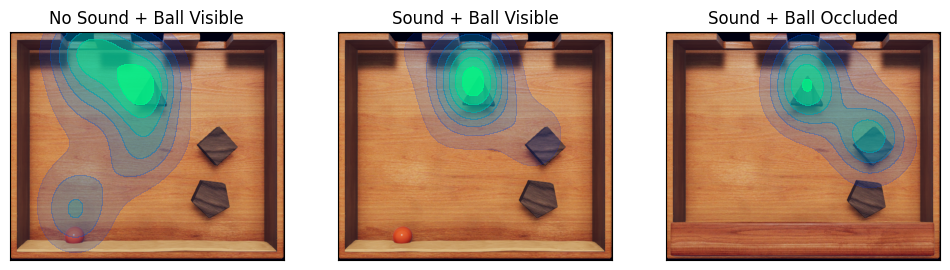

In [14]:
visualize_human_cross_cond(78)

### Trial 2

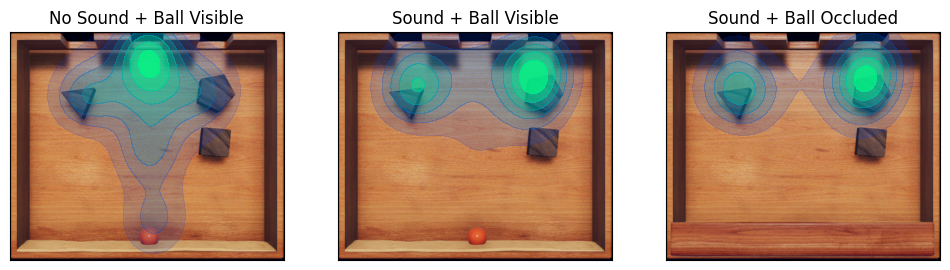

In [15]:
visualize_human_cross_cond(1)

### Trial 3

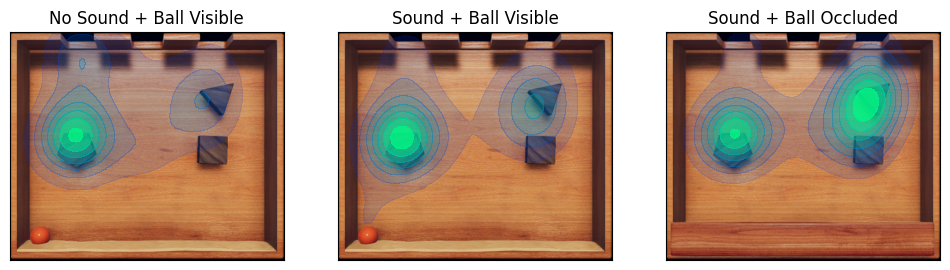

In [16]:
visualize_human_cross_cond(20)

### Trial 4

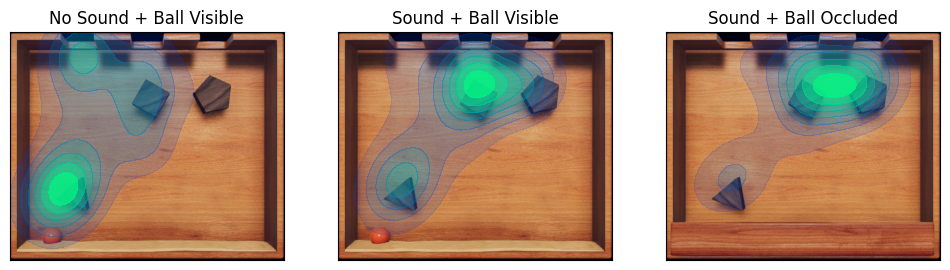

In [17]:
visualize_human_cross_cond(332)

# Figure 4 Model Illustration

In [22]:
# Setup agent
evidence = "vision_sound_independent"

bw_vis = 20
bw_aud = 0.4
sample_weight = 10

counts, update_mask = agent_utils.initialize_agent_vars(
    evidence,
    600,
    6,
    None,
    bw_vis,
    bw_aud,
    None
)

# setup world
world_num = 78
world, _, ncol = agent_utils.get_world(world_num)
hole_pos = np.array(np.round(world["hole_positions_unity"]), dtype=int)
ball_pos = int(np.round(world["ball_final_position_unity"]["x"]))

vision_counts, sound_counts, _ = counts
vision_masks, sound_masks, _ = update_mask

### Initialization

<Axes: >

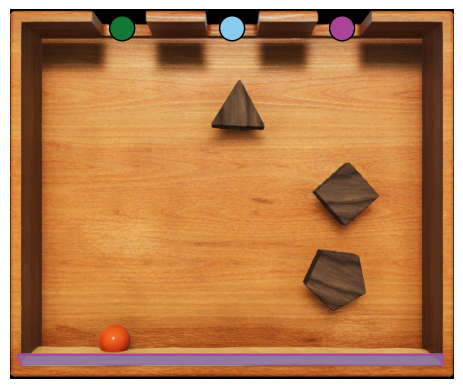

In [36]:
vision_like = compute_pmf(vision_counts)
plot_visual_likelihood(world_num, vision_like)

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

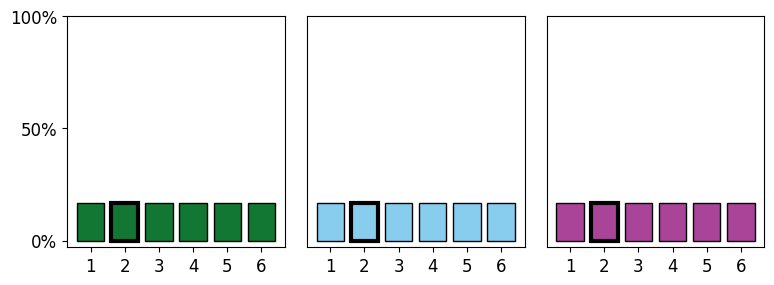

In [37]:
sound_like = compute_pmf(sound_counts)
plot_sound_likelihood(sound_like, 2)

<BarContainer object of 3 artists>

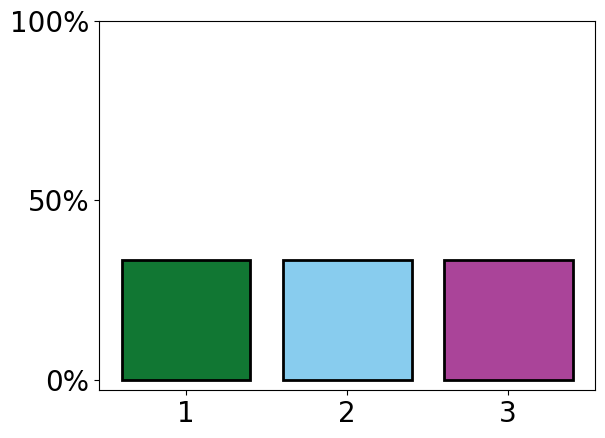

In [38]:
posterior = compute_posterior_indep(vision_like, sound_like, ball_pos, ncol)
plot_posterior(posterior)

### Simulation 1

In [39]:
np.random.seed(1)
xs, ys, fp = visual.simulate_drop(world, 0)

sim_ball_pos = int(np.round(fp[0]))
sim_ncol = 1

# sample_weight = 20
vision_counts[0] += vision_masks[sim_ball_pos]*sample_weight
sound_counts[0] += sound_masks[sim_ncol-1]*sample_weight

vision_like = compute_pmf(vision_counts)
sound_like = compute_pmf(sound_counts)

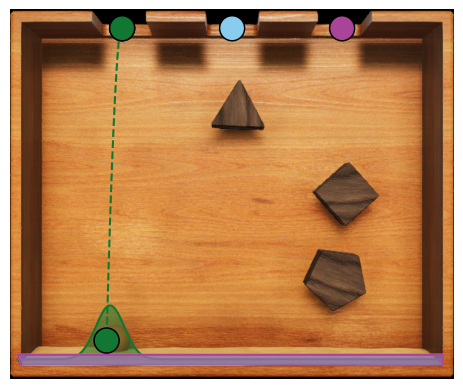

In [40]:
ax = plot_visual_likelihood(world_num, vision_like)
ax = visual.draw_drop(ax, 0, world, xs, ys, fp, colors=colors)

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

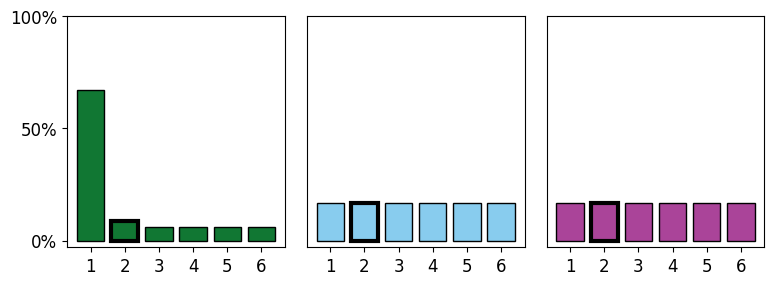

In [41]:
plot_sound_likelihood(sound_like, 2)

<BarContainer object of 3 artists>

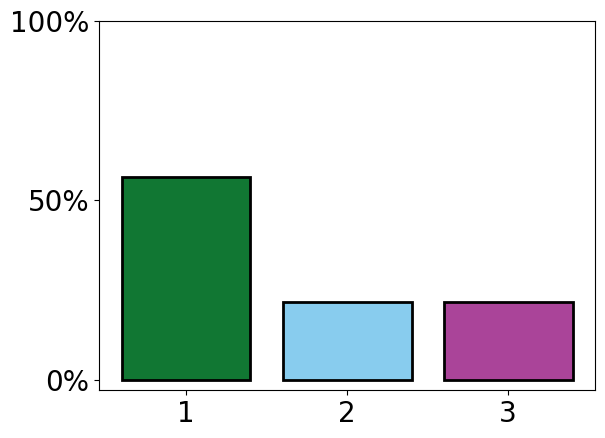

In [42]:
posterior = compute_posterior_indep(vision_like, sound_like, ball_pos, ncol)
plot_posterior(posterior)

### Simulation 2

In [43]:
np.random.seed(7)
xs, ys, fp = visual.simulate_drop(world, 1)

sim_ball_pos = int(np.round(fp[0]))
sim_ncol = 2

vision_counts[1] += vision_masks[sim_ball_pos]*sample_weight
sound_counts[1] += sound_masks[sim_ncol-1]*sample_weight

vision_like = compute_pmf(vision_counts)
sound_like = compute_pmf(sound_counts)

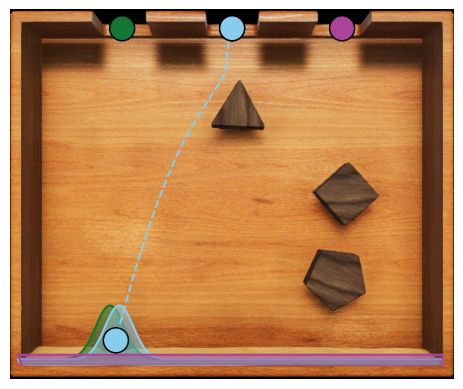

In [44]:
ax = plot_visual_likelihood(world_num, vision_like)
ax = visual.draw_drop(ax, 1, world, xs, ys, fp, colors=colors)

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

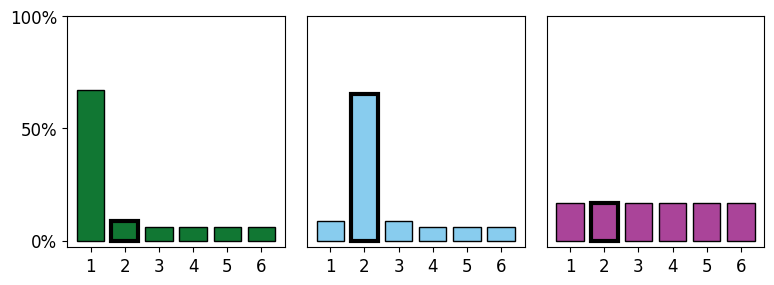

In [45]:
plot_sound_likelihood(sound_like, 2)

<BarContainer object of 3 artists>

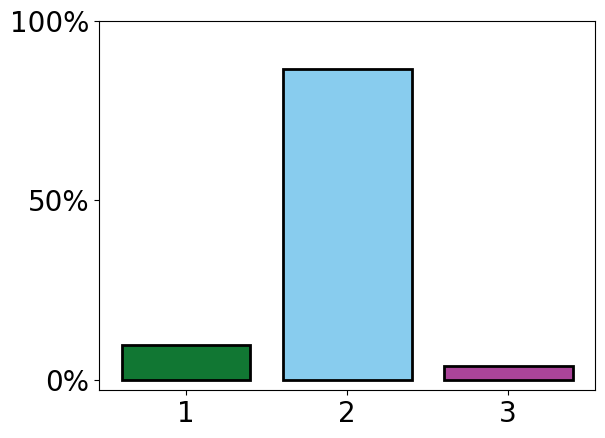

In [46]:
posterior = compute_posterior_indep(vision_like, sound_like, ball_pos, ncol)
plot_posterior(posterior)

# Figure 5

## Regression Illustration

In [49]:
path = "model_performance/collisions/"

sequential_vision_filename = create_filename("sequential", "vision_independent", hole_select="proportional", num_samples=100, vbw=100, vision_prior="uniform", audio_prior="uniform", phys_params=(0.3, 0.0, 0.7))
uniform_vision_filename = create_filename("uniform", "vision_independent", num_samples=100, vbw=10, phys_params=(0.3, 0.0, 0.7))

seq_model_events = r.load_model_perf(path + sequential_vision_filename)
uniform_model_events = r.load_model_perf(path + uniform_vision_filename)

In [50]:
reg_seq, pred_seq, features_seq, labels_seq = r.compute_regression(seq_model_events, "sequential", "vision", cut=300)
reg_uniform, pred_uniform, features_uniform, labels_uniform = r.compute_regression(uniform_model_events, "uniform", "vision", cut=300)
reg_vf, pred_vf, features_vf, labels_vf = r.compute_regression(None, "visual_features", "vision", cut=300)

In [51]:
tr_num = 20

### Visual Features

<Axes: >

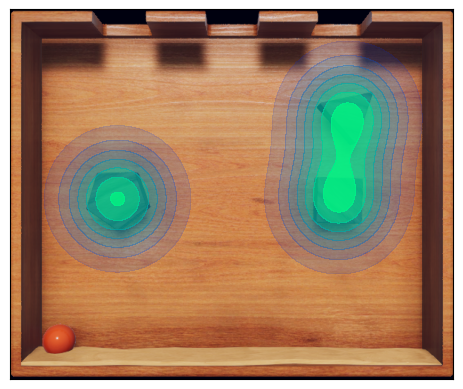

In [63]:
obs_hm = get_trial_hm(tr_num, features_vf[:, 0])
obs_hm[obs_hm < 0] = 0
visualize_heatmap(obs_hm, tr_num, condition="vision")

<Axes: >

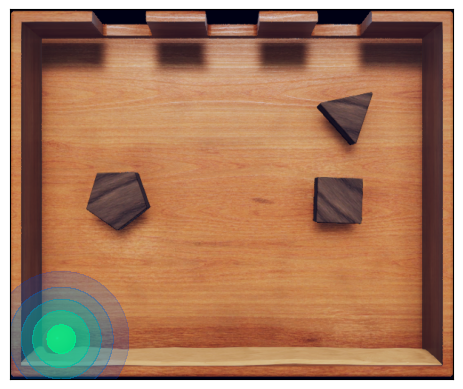

In [64]:
ball_hm = get_trial_hm(tr_num, features_vf[:, 1])
ball_hm[ball_hm < 0] = 0
visualize_heatmap(ball_hm, tr_num, condition="vision")

<Axes: >

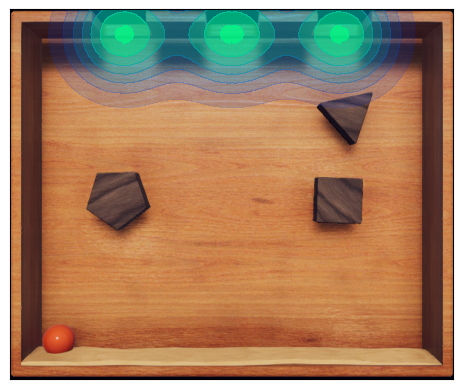

In [65]:
hole_hm = get_trial_hm(tr_num, features_vf[:, 2])
hole_hm[hole_hm < 0] = 0
visualize_heatmap(hole_hm, tr_num, condition="vision")

<Axes: >

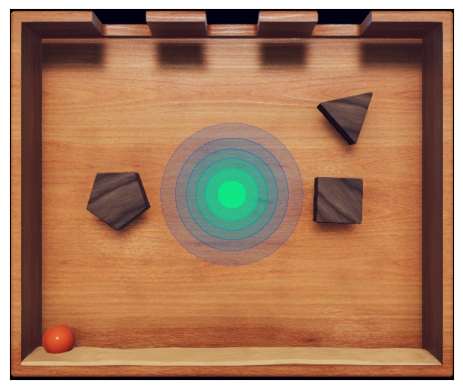

In [66]:
center_hm = get_trial_hm(tr_num, features_vf[:, 3])
center_hm[center_hm < 0] = 0
visualize_heatmap(center_hm, tr_num, condition="vision")

### Sequential Features

<Axes: >

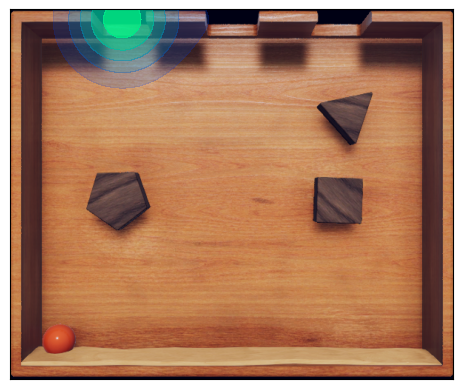

In [55]:
seq_drop_hm = get_trial_hm(tr_num, features_seq[:, 4])
seq_drop_hm[seq_drop_hm < 0] = 0
visualize_heatmap(seq_drop_hm, tr_num, condition="vision")

<Axes: >

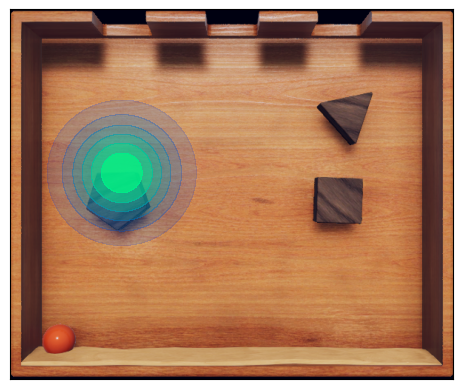

In [56]:
seq_obs_col_hm = get_trial_hm(tr_num, features_seq[:, 5])
seq_obs_col_hm[seq_obs_col_hm < 0] = 0
visualize_heatmap(seq_obs_col_hm, tr_num, condition="vision")

<Axes: >

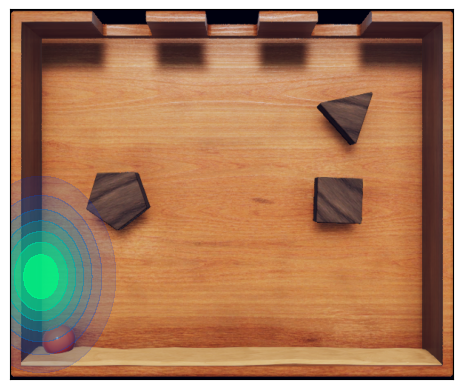

In [57]:
seq_wall_col_hm = get_trial_hm(tr_num, features_seq[:, 6])
seq_wall_col_hm[seq_wall_col_hm < 0] = 0
visualize_heatmap(seq_wall_col_hm, tr_num, condition="vision")

<Axes: >

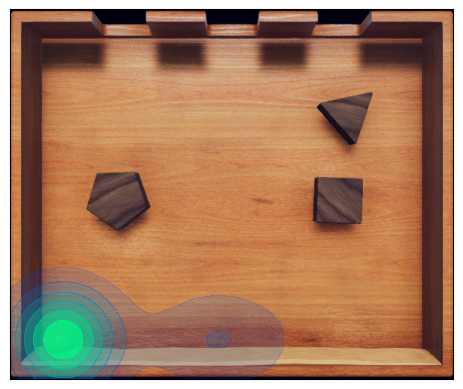

In [58]:
seq_ground_col_hm = get_trial_hm(tr_num, features_seq[:, 7])
seq_ground_col_hm[seq_ground_col_hm < 0] = 0
visualize_heatmap(seq_ground_col_hm, tr_num, condition="vision")

### Uniform Features

<Axes: >

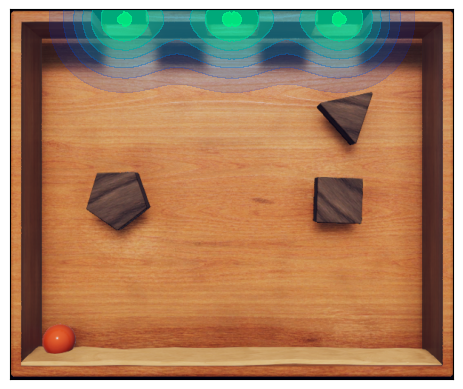

In [59]:
uni_drop_hm = get_trial_hm(tr_num, features_uniform[:, 4])
uni_drop_hm[uni_drop_hm < 0] = 0
visualize_heatmap(uni_drop_hm, tr_num, condition="vision")

<Axes: >

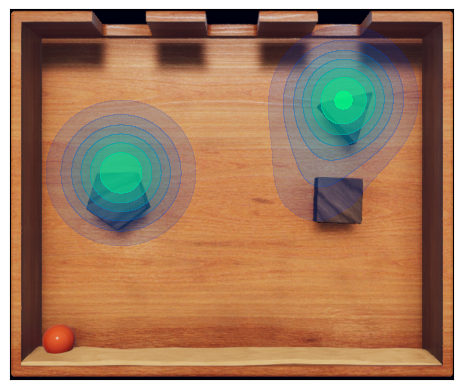

In [60]:
uni_obs_col_hm = get_trial_hm(tr_num, features_uniform[:, 5])
uni_obs_col_hm[uni_obs_col_hm < 0] = 0
visualize_heatmap(uni_obs_col_hm, tr_num, condition="vision")

<Axes: >

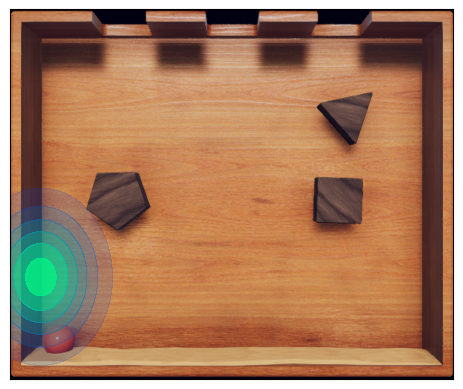

In [61]:
uni_wall_col_hm = get_trial_hm(tr_num, features_uniform[:, 6])
uni_wall_col_hm[uni_wall_col_hm < 0] = 0
visualize_heatmap(uni_wall_col_hm, tr_num, condition="vision")

<Axes: >

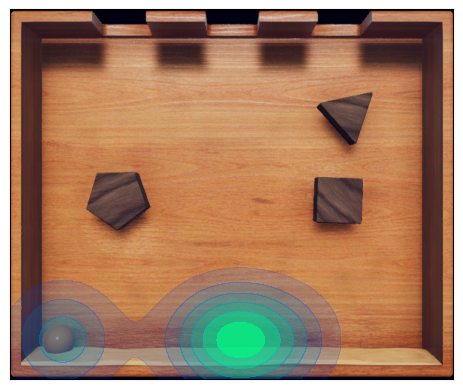

In [62]:
uni_ground_col_hm = get_trial_hm(tr_num, features_uniform[:, 7])
uni_ground_col_hm[uni_ground_col_hm < 0] = 0
visualize_heatmap(uni_ground_col_hm, tr_num, condition="vision")

### Predictions

<Axes: >

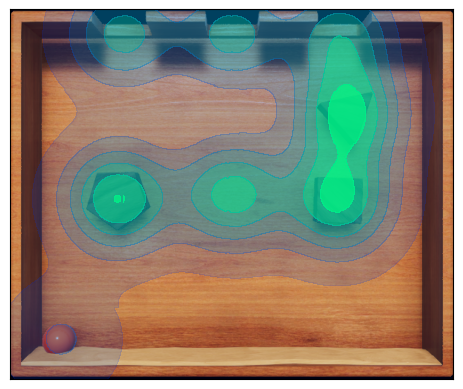

In [67]:
# Visual Features
vf_hm = get_trial_hm(tr_num, pred_vf)
vf_hm[vf_hm < 0] = 0
visualize_heatmap(vf_hm, tr_num, condition="vision")

<Axes: >

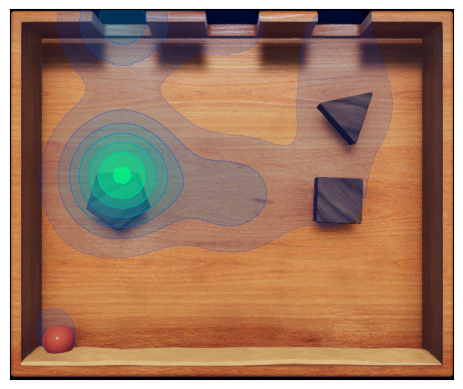

In [68]:
# Sequential Sampler

seq_hm = get_trial_hm(tr_num, pred_seq)
seq_hm[seq_hm < 0] = 0
visualize_heatmap(seq_hm, tr_num, condition="vision")

<Axes: >

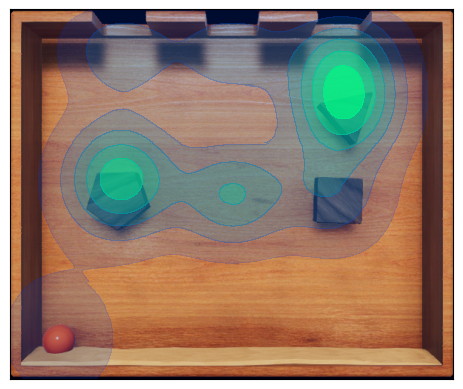

In [69]:
# Uniform Sampler

uni_hm = get_trial_hm(tr_num, pred_uniform)
uni_hm[uni_hm < 0] = 0
visualize_heatmap(uni_hm, tr_num, condition="vision")

## Cross Condition Model Comparison

### Compute other condition models

In [71]:
sequential_audio_filename = create_filename("sequential", "vision_sound_independent", hole_select="proportional", num_samples=100, vbw=100, sbw=0.4, vision_prior="uniform", audio_prior="uniform", phys_params=(0.3, 0.0, 0.7))
uniform_audio_filename = create_filename("uniform", "vision_sound_independent", num_samples=100, vbw=10, sbw=0.4, phys_params=(0.3, 0.0, 0.7))

seq_audio_model_events = r.load_model_perf(path + sequential_audio_filename)
uniform_audio_model_events = r.load_model_perf(path + uniform_audio_filename)

In [72]:
_, pred_seq_audio, _, _ = r.compute_regression(seq_audio_model_events, "sequential", "audio", cut=300)
_, pred_uniform_audio, _, _ = r.compute_regression(uniform_audio_model_events, "uniform", "audio", cut=300)
_, pred_vf_audio, _, _ = r.compute_regression(None, "visual_features", "audio", cut=300)

In [73]:
sequential_occluded_filename = create_filename("sequential", "sound_independent", hole_select="proportional", num_samples=100, sbw=0.4, vision_prior="uniform", audio_prior="uniform", phys_params=(0.3, 0.0, 0.7))
uniform_occluded_filename = create_filename("uniform", "sound_independent", num_samples=100, sbw=0.4, phys_params=(0.3, 0.0, 0.7))

seq_occluded_model_events = r.load_model_perf(path + sequential_occluded_filename)
uniform_occluded_model_events = r.load_model_perf(path + uniform_occluded_filename)

In [74]:
_, pred_seq_occluded, _, _ = r.compute_regression(seq_occluded_model_events, "sequential", "occluded", cut=300)
_, pred_uniform_occluded, _, _ = r.compute_regression(uniform_occluded_model_events, "uniform", "occluded", cut=300)
_, pred_vf_occluded, _, _ = r.compute_regression(None, "visual_features", "occluded", cut=300)

### Visualizations

array([<Axes: title={'center': 'Human'}>,
       <Axes: title={'center': 'Sequential Sampler'}>,
       <Axes: title={'center': 'Uniform Sampler'}>,
       <Axes: title={'center': 'Visual Features'}>], dtype=object)

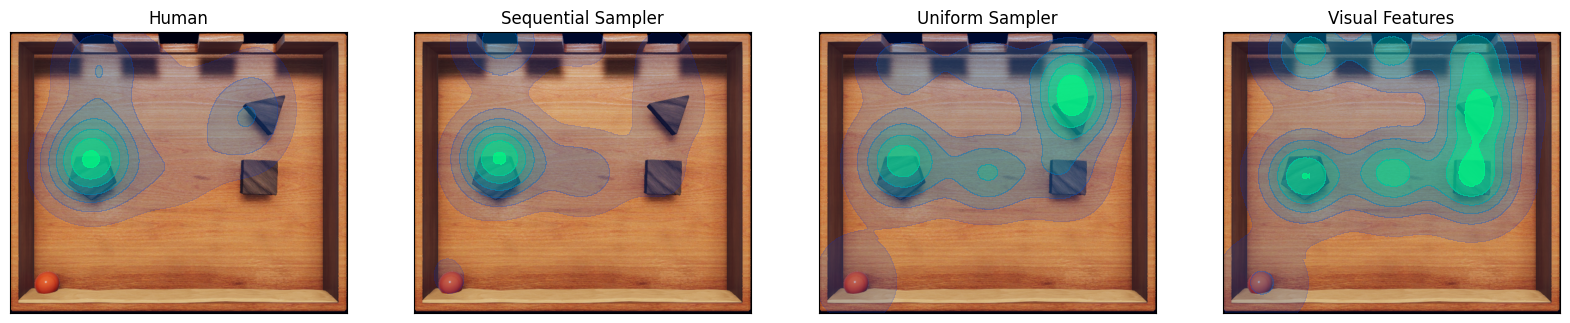

In [87]:
visualize_trial("vision", tr_num, pred_seq, pred_uniform, vf_pred=pred_vf, cut=300, model_titles=["Human", "Sequential Sampler", "Uniform Sampler", "Visual Features"])

array([<Axes: title={'center': 'Human'}>,
       <Axes: title={'center': 'Sequential Sampler'}>,
       <Axes: title={'center': 'Uniform Sampler'}>,
       <Axes: title={'center': 'Visual Features'}>], dtype=object)

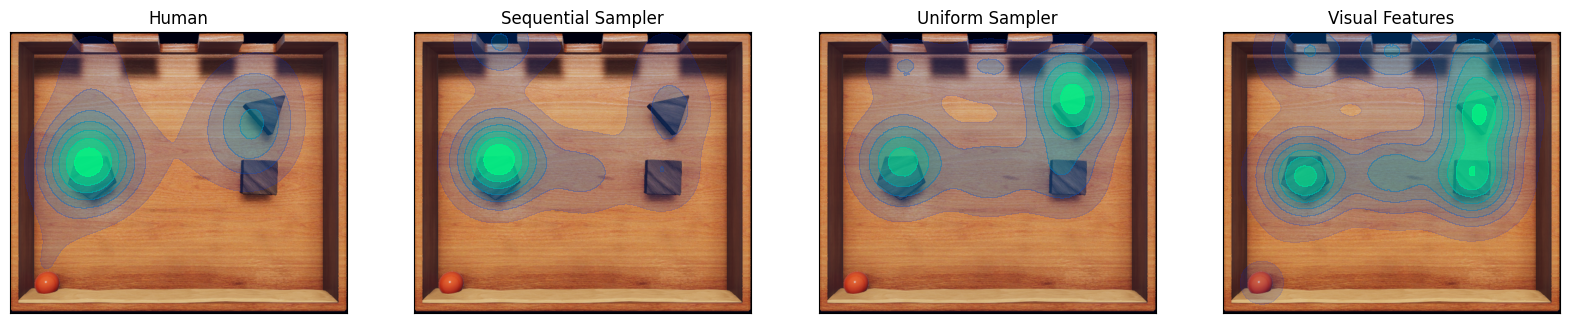

In [86]:
visualize_trial("audio", tr_num, pred_seq_audio, pred_uniform_audio, vf_pred=pred_vf_audio, cut=300, model_titles=["Human", "Sequential Sampler", "Uniform Sampler", "Visual Features"])

array([<Axes: title={'center': 'Human'}>,
       <Axes: title={'center': 'Sequential Sampler'}>,
       <Axes: title={'center': 'Uniform Sampler'}>,
       <Axes: title={'center': 'Visual Features'}>], dtype=object)

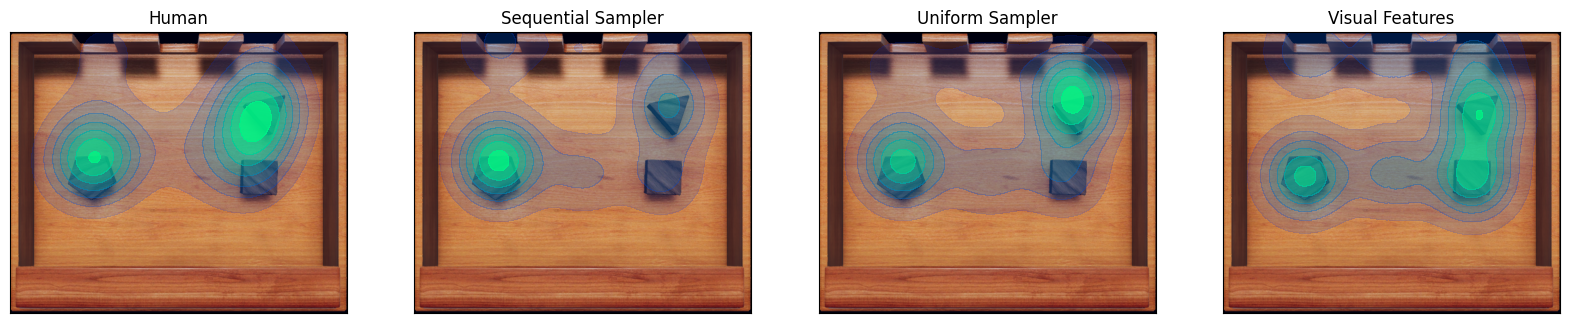

In [85]:
visualize_trial("occluded", tr_num, pred_seq_occluded, pred_uniform_occluded, vf_pred=pred_vf_occluded, cut=300, model_titles=["Human", "Sequential Sampler", "Uniform Sampler", "Visual Features"])